**References:**

1. https://keras.io/api/applications/
2. https://keras.io/guides/transfer_learning/

In [1]:
!nvidia-smi

Wed Feb 10 07:46:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

P100

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd '/content/gdrive/MyDrive/Journal_paper'
! ls

In [4]:
# import the basic libraries
import numpy as np
import tensorflow as tf 
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Activation, Flatten, Reshape, ReLU
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout
from keras.layers import GlobalAveragePooling2D, Concatenate, Lambda, add
from keras.optimizers import Adam, RMSprop
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from glob import glob

**1. Xception**

In [5]:
from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input

# re-size all the images to this
IMAGE_SIZE = [299, 299]

train_path = '/content/gdrive/MyDrive/Journal_paper/Database/train'
valid_path = '/content/gdrive/MyDrive/Journal_paper/Database/valid'
test_path = '/content/gdrive/MyDrive/Journal_paper/Database/test'

In [6]:
# add preprocessing layer to the front of Xception
xception = Xception(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

83689472/83683744 [==============================] - 1s 0us/step


In [7]:
# don't train existing weights
for layer in xception.layers:
  layer.trainable = False

In [8]:
# useful for getting number of classes
folders = glob('/content/gdrive/MyDrive/Journal_paper/Database/train/*')

In [9]:
# our layers - you can add more if you want
x = Flatten()(xception.output)

In [10]:
#x = Dense(3, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

In [11]:
# create a model object
model = Model(inputs=xception.input, outputs=prediction)

In [12]:
# view the structure of the model
#model.summary()

In [13]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [14]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

valid_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

# Flow training images in batches of 64 using train_datagen generator
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (299, 299),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

valid_set = valid_datagen.flow_from_directory(valid_path,
                                                 target_size = (299, 299),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (299, 299),
                                            batch_size = 64,
                                            class_mode = 'categorical')

Found 840 images belonging to 3 classes.
Found 180 images belonging to 3 classes.
Found 180 images belonging to 3 classes.


In [15]:
# fit the model
xception = model.fit(
  training_set,
  validation_data=valid_set,
  epochs=50,
  steps_per_epoch=len(training_set),
  validation_steps=len(valid_set)
)

Epoch 1/50
14/14 [==============================] - 313s 22s/step - loss: 4.5732 - accuracy: 0.4440 - val_loss: 3.0332 - val_accuracy: 0.6667
Epoch 2/50
14/14 [==============================] - 21s 1s/step - loss: 2.4786 - accuracy: 0.6835 - val_loss: 0.8955 - val_accuracy: 0.8278
Epoch 3/50
14/14 [==============================] - 21s 2s/step - loss: 1.5530 - accuracy: 0.7754 - val_loss: 1.0111 - val_accuracy: 0.8222
Epoch 4/50
14/14 [==============================] - 21s 1s/step - loss: 0.8458 - accuracy: 0.8528 - val_loss: 0.5638 - val_accuracy: 0.9000
Epoch 5/50
14/14 [==============================] - 21s 1s/step - loss: 0.5520 - accuracy: 0.8799 - val_loss: 0.9123 - val_accuracy: 0.8389
Epoch 6/50
14/14 [==============================] - 21s 1s/step - loss: 0.4598 - accuracy: 0.8889 - val_loss: 0.5371 - val_accuracy: 0.8889
Epoch 7/50
14/14 [==============================] - 21s 1s/step - loss: 0.3417 - accuracy: 0.9066 - val_loss: 0.6825 - val_accuracy: 0.8722
Epoch 8/50
14/14 [

In [16]:
# testing
score = model.evaluate(test_set, verbose=0)
print(f'Test loss: {score[0]:.4f}')
print(f'Test accuracy: {score[1]:.4f}')

Test loss: 0.4970
Test accuracy: 0.9500


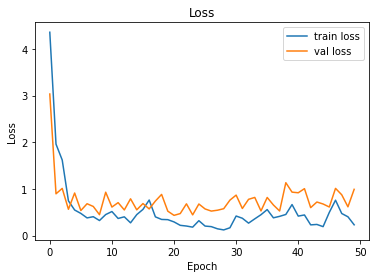

In [17]:
# loss
plt.plot(xception.history['loss'], label='train loss')
plt.plot(xception.history['val_loss'], label='val loss')
plt.title(label = 'Loss', fontsize = 12, color = "black")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
#plt.savefig('Xception_loss')

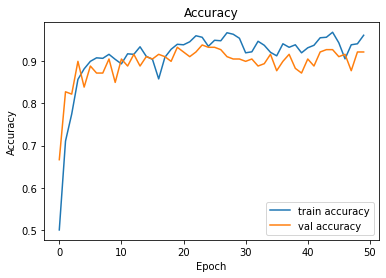

In [18]:
# accuracy
plt.plot(xception.history['accuracy'], label='train accuracy')
plt.plot(xception.history['val_accuracy'], label='val accuracy')
plt.title(label = 'Accuracy', fontsize = 12, color = "black")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
#plt.savefig('Xception_accuracy')

**2. VGG16**

In [19]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = '/content/gdrive/MyDrive/Journal_paper/Database/train'
valid_path = '/content/gdrive/MyDrive/Journal_paper/Database/valid'
test_path = '/content/gdrive/MyDrive/Journal_paper/Database/test'

In [20]:
# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

58892288/58889256 [==============================] - 0s 0us/step


In [21]:
# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False

In [22]:
# useful for getting number of classes
folders = glob('/content/gdrive/MyDrive/Journal_paper/Database/train/*')

In [23]:
# our layers - you can add more if you want
x = Flatten()(vgg.output)

In [24]:
#x = Dense(3, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

In [25]:
# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

In [26]:
# view the structure of the model
#model.summary()

In [27]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [28]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

valid_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

# Flow training images in batches of 64 using train_datagen generator
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

valid_set = valid_datagen.flow_from_directory(valid_path,
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 64,
                                            class_mode = 'categorical')

Found 840 images belonging to 3 classes.
Found 180 images belonging to 3 classes.
Found 180 images belonging to 3 classes.


In [29]:
# fit the model
vgg16 = model.fit(
  training_set,
  validation_data=valid_set,
  epochs=50,
  steps_per_epoch=len(training_set),
  validation_steps=len(valid_set)
)

Epoch 1/50
14/14 [==============================] - 16s 995ms/step - loss: 1.5660 - accuracy: 0.3395 - val_loss: 1.0276 - val_accuracy: 0.5111
Epoch 2/50
14/14 [==============================] - 13s 916ms/step - loss: 1.0103 - accuracy: 0.4683 - val_loss: 1.0182 - val_accuracy: 0.4111
Epoch 3/50
14/14 [==============================] - 13s 906ms/step - loss: 0.9607 - accuracy: 0.5040 - val_loss: 0.7880 - val_accuracy: 0.6167
Epoch 4/50
14/14 [==============================] - 13s 906ms/step - loss: 0.8106 - accuracy: 0.6715 - val_loss: 0.6904 - val_accuracy: 0.7222
Epoch 5/50
14/14 [==============================] - 13s 894ms/step - loss: 0.7406 - accuracy: 0.7394 - val_loss: 0.7959 - val_accuracy: 0.6333
Epoch 6/50
14/14 [==============================] - 13s 898ms/step - loss: 0.7715 - accuracy: 0.6663 - val_loss: 0.6971 - val_accuracy: 0.6944
Epoch 7/50
14/14 [==============================] - 12s 878ms/step - loss: 0.6661 - accuracy: 0.7626 - val_loss: 0.5387 - val_accuracy: 0.8333

In [30]:
# testing
score = model.evaluate(test_set, verbose=0)
print(f'Test loss: {score[0]:.4f}')
print(f'Test accuracy: {score[1]:.4f}')

Test loss: 0.4095
Test accuracy: 0.8167


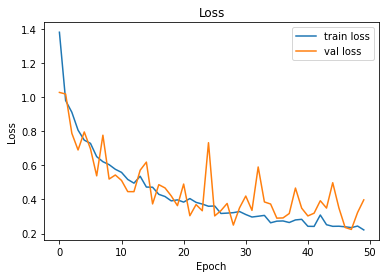

In [31]:
# loss
plt.plot(vgg16.history['loss'], label='train loss')
plt.plot(vgg16.history['val_loss'], label='val loss')
plt.title(label = 'Loss', fontsize = 12, color = "black")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
#plt.savefig('VGG16_loss')

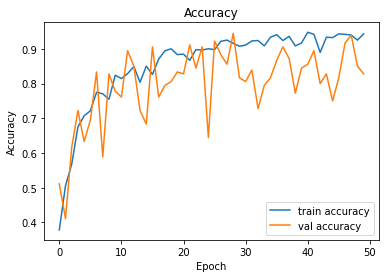

In [32]:
# accuracy
plt.plot(vgg16.history['accuracy'], label='train accuracy')
plt.plot(vgg16.history['val_accuracy'], label='val accuracy')
plt.title(label = 'Accuracy', fontsize = 12, color = "black")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
#plt.savefig('VGG16_accuracy')

**3. ResNet50**

In [33]:
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input

# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = '/content/gdrive/MyDrive/Journal_paper/Database/train'
valid_path = '/content/gdrive/MyDrive/Journal_paper/Database/valid'
test_path = '/content/gdrive/MyDrive/Journal_paper/Database/test'

In [34]:
# add preprocessing layer to the front of ResNet
resnet = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

94773248/94765736 [==============================] - 1s 0us/step


In [35]:
# don't train existing weights
for layer in resnet.layers:
  layer.trainable = False

In [36]:
# useful for getting number of classes
folders = glob('/content/gdrive/MyDrive/Journal_paper/Database/train/*')

In [37]:
# our layers - you can add more if you want
x = Flatten()(resnet.output)

In [38]:
#x = Dense(3, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

In [39]:
# create a model object
model = Model(inputs=resnet.input, outputs=prediction)

In [40]:
# view the structure of the model
#model.summary()

In [41]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [42]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

valid_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

# Flow training images in batches of 64 using train_datagen generator
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

valid_set = valid_datagen.flow_from_directory(valid_path,
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 64,
                                            class_mode = 'categorical')

Found 840 images belonging to 3 classes.
Found 180 images belonging to 3 classes.
Found 180 images belonging to 3 classes.


In [43]:
# fit the model
resnet = model.fit(
  training_set,
  validation_data=valid_set,
  epochs=50,
  steps_per_epoch=len(training_set),
  validation_steps=len(valid_set)
)

Epoch 1/50
14/14 [==============================] - 17s 996ms/step - loss: 5.1053 - accuracy: 0.3329 - val_loss: 2.7382 - val_accuracy: 0.3333
Epoch 2/50
14/14 [==============================] - 12s 872ms/step - loss: 2.8404 - accuracy: 0.3440 - val_loss: 3.7769 - val_accuracy: 0.3333
Epoch 3/50
14/14 [==============================] - 12s 858ms/step - loss: 2.6776 - accuracy: 0.3476 - val_loss: 2.2527 - val_accuracy: 0.3333
Epoch 4/50
14/14 [==============================] - 12s 854ms/step - loss: 1.8614 - accuracy: 0.3038 - val_loss: 1.5447 - val_accuracy: 0.3333
Epoch 5/50
14/14 [==============================] - 12s 877ms/step - loss: 1.4293 - accuracy: 0.3615 - val_loss: 1.2075 - val_accuracy: 0.3333
Epoch 6/50
14/14 [==============================] - 12s 855ms/step - loss: 1.2397 - accuracy: 0.3388 - val_loss: 1.0903 - val_accuracy: 0.3333
Epoch 7/50
14/14 [==============================] - 12s 870ms/step - loss: 1.1611 - accuracy: 0.3710 - val_loss: 1.0852 - val_accuracy: 0.5278

In [44]:
# testing
score = model.evaluate(test_set, verbose=0)
print(f'Test loss: {score[0]:.4f}')
print(f'Test accuracy: {score[1]:.4f}')

Test loss: 1.4093
Test accuracy: 0.3333


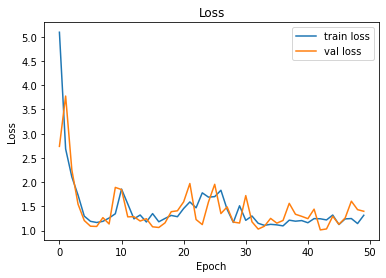

In [45]:
# loss
plt.plot(resnet.history['loss'], label='train loss')
plt.plot(resnet.history['val_loss'], label='val loss')
plt.title(label = 'Loss', fontsize = 12, color = "black")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
#plt.savefig('ResNet50_loss')

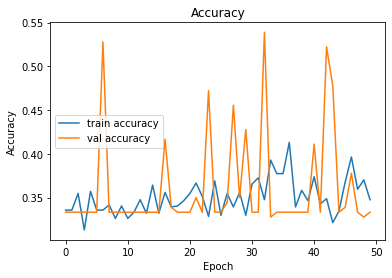

In [46]:
# accuracy
plt.plot(resnet.history['accuracy'], label='train accuracy')
plt.plot(resnet.history['val_accuracy'], label='val accuracy')
plt.title(label = 'Accuracy', fontsize = 12, color = "black")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
#plt.savefig('ResNet50_accuracy')

**4. InceptionV3**

In [48]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input

# re-size all the images to this
IMAGE_SIZE = [299, 299]

train_path = '/content/gdrive/MyDrive/Journal_paper/Database/train'
valid_path = '/content/gdrive/MyDrive/Journal_paper/Database/valid'
test_path = '/content/gdrive/MyDrive/Journal_paper/Database/test'

In [49]:
# add preprocessing layer to the front of Inception
inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

87916544/87910968 [==============================] - 1s 0us/step


In [50]:
# don't train existing weights
for layer in inception.layers:
  layer.trainable = False

In [51]:
# useful for getting number of classes
folders = glob('/content/gdrive/MyDrive/Journal_paper/Database/train/*')

In [52]:
# our layers - you can add more if you want
x = Flatten()(inception.output)

In [53]:
#x = Dense(3, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

In [54]:
# create a model object
model = Model(inputs=inception.input, outputs=prediction)

In [55]:
# view the structure of the model
#model.summary()

In [56]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [57]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

valid_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

# Flow training images in batches of 64 using train_datagen generator
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (299, 299),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

valid_set = valid_datagen.flow_from_directory(valid_path,
                                                 target_size = (299, 299),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (299, 299),
                                            batch_size = 64,
                                            class_mode = 'categorical')

Found 840 images belonging to 3 classes.
Found 180 images belonging to 3 classes.
Found 180 images belonging to 3 classes.


In [58]:
# fit the model
inception = model.fit(
  training_set,
  validation_data=valid_set,
  epochs=50,
  steps_per_epoch=len(training_set),
  validation_steps=len(valid_set)
)

Epoch 1/50
14/14 [==============================] - 27s 2s/step - loss: 15.2315 - accuracy: 0.3960 - val_loss: 5.1209 - val_accuracy: 0.5778
Epoch 2/50
14/14 [==============================] - 19s 1s/step - loss: 3.6573 - accuracy: 0.6168 - val_loss: 1.5082 - val_accuracy: 0.7889
Epoch 3/50
14/14 [==============================] - 19s 1s/step - loss: 2.0810 - accuracy: 0.7751 - val_loss: 1.3283 - val_accuracy: 0.7944
Epoch 4/50
14/14 [==============================] - 19s 1s/step - loss: 0.9879 - accuracy: 0.8398 - val_loss: 1.3087 - val_accuracy: 0.8556
Epoch 5/50
14/14 [==============================] - 19s 1s/step - loss: 0.9359 - accuracy: 0.8629 - val_loss: 1.8444 - val_accuracy: 0.7833
Epoch 6/50
14/14 [==============================] - 19s 1s/step - loss: 0.6308 - accuracy: 0.8749 - val_loss: 0.5886 - val_accuracy: 0.9222
Epoch 7/50
14/14 [==============================] - 19s 1s/step - loss: 0.6025 - accuracy: 0.8937 - val_loss: 0.4435 - val_accuracy: 0.9167
Epoch 8/50
14/14 [=

In [59]:
# testing
score = model.evaluate(test_set, verbose=0)
print(f'Test loss: {score[0]:.4f}')
print(f'Test accuracy: {score[1]:.4f}')

Test loss: 0.4340
Test accuracy: 0.9444


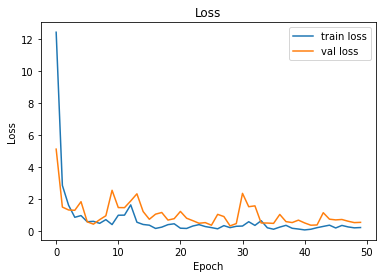

In [60]:
# loss
plt.plot(inception.history['loss'], label='train loss')
plt.plot(inception.history['val_loss'], label='val loss')
plt.title(label = 'Loss', fontsize = 12, color = "black")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
#plt.savefig('InceptionV3_loss')

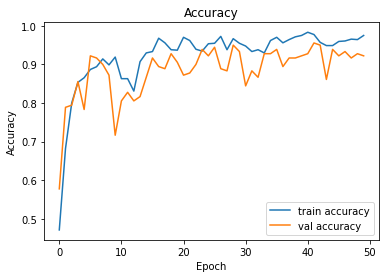

In [61]:
# accuracy
plt.plot(inception.history['accuracy'], label='train accuracy')
plt.plot(inception.history['val_accuracy'], label='val accuracy')
plt.title(label = 'Accuracy', fontsize = 12, color = "black")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
#plt.savefig('InceptionV3_accuracy')

**5. MobileNet**

In [65]:
from keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet import preprocess_input

# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = '/content/gdrive/MyDrive/Journal_paper/Database/train'
valid_path = '/content/gdrive/MyDrive/Journal_paper/Database/valid'
test_path = '/content/gdrive/MyDrive/Journal_paper/Database/test'

In [66]:
# add preprocessing layer to the front of MobileNet
mobilenet = MobileNet(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [67]:
# don't train existing weights
for layer in mobilenet.layers:
  layer.trainable = False

In [68]:
# useful for getting number of classes
folders = glob('/content/gdrive/MyDrive/Journal_paper/Database/train/*')

In [69]:
# our layers - you can add more if you want
x = Flatten()(mobilenet.output)

In [70]:
#x = Dense(3, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

In [71]:
# create a model object
model = Model(inputs=mobilenet.input, outputs=prediction)

In [72]:
# view the structure of the model
#model.summary()

In [73]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [74]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

valid_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

# Flow training images in batches of 64 using train_datagen generator
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

valid_set = valid_datagen.flow_from_directory(valid_path,
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 64,
                                            class_mode = 'categorical')

Found 840 images belonging to 3 classes.
Found 180 images belonging to 3 classes.
Found 180 images belonging to 3 classes.


In [75]:
# fit the model
mobilenet = model.fit(
  training_set,
  validation_data=valid_set,
  epochs=50,
  steps_per_epoch=len(training_set),
  validation_steps=len(valid_set)
)

Epoch 1/50
14/14 [==============================] - 14s 877ms/step - loss: 4.7180 - accuracy: 0.4989 - val_loss: 1.5700 - val_accuracy: 0.7778
Epoch 2/50
14/14 [==============================] - 11s 811ms/step - loss: 0.7626 - accuracy: 0.8390 - val_loss: 0.3319 - val_accuracy: 0.9222
Epoch 3/50
14/14 [==============================] - 11s 815ms/step - loss: 0.3851 - accuracy: 0.9001 - val_loss: 0.1438 - val_accuracy: 0.9444
Epoch 4/50
14/14 [==============================] - 11s 815ms/step - loss: 0.3055 - accuracy: 0.9367 - val_loss: 0.3158 - val_accuracy: 0.8889
Epoch 5/50
14/14 [==============================] - 11s 805ms/step - loss: 0.1556 - accuracy: 0.9547 - val_loss: 0.2315 - val_accuracy: 0.9000
Epoch 6/50
14/14 [==============================] - 11s 805ms/step - loss: 0.0906 - accuracy: 0.9657 - val_loss: 0.1171 - val_accuracy: 0.9611
Epoch 7/50
14/14 [==============================] - 11s 818ms/step - loss: 0.1782 - accuracy: 0.9394 - val_loss: 0.1772 - val_accuracy: 0.9556

In [76]:
# testing
score = model.evaluate(test_set, verbose=0)
print(f'Test loss: {score[0]:.4f}')
print(f'Test accuracy: {score[1]:.4f}')

Test loss: 0.1138
Test accuracy: 0.9778


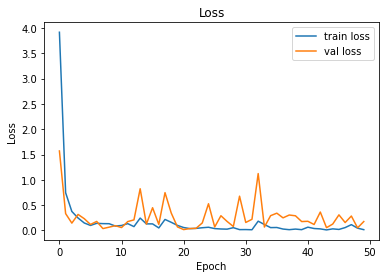

In [77]:
# loss
plt.plot(mobilenet.history['loss'], label='train loss')
plt.plot(mobilenet.history['val_loss'], label='val loss')
plt.title(label = 'Loss', fontsize = 12, color = "black")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
#plt.savefig('MobileNet_loss')

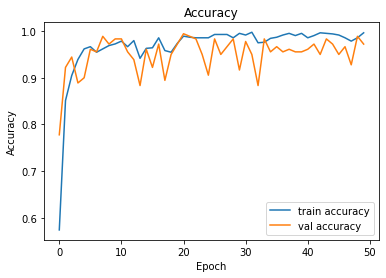

In [78]:
# accuracy
plt.plot(mobilenet.history['accuracy'], label='train accuracy')
plt.plot(mobilenet.history['val_accuracy'], label='val accuracy')
plt.title(label = 'Accuracy', fontsize = 12, color = "black")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
#plt.savefig('MobileNet_accuracy')

**6. DenseNet121**

In [79]:
from keras.applications.densenet import DenseNet121
from keras.applications.densenet import preprocess_input

# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = '/content/gdrive/MyDrive/Journal_paper/Database/train'
valid_path = '/content/gdrive/MyDrive/Journal_paper/Database/valid'
test_path = '/content/gdrive/MyDrive/Journal_paper/Database/test'

In [80]:
# add preprocessing layer to the front of DenseNet
densenet = DenseNet121(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

29089792/29084464 [==============================] - 0s 0us/step


In [81]:
# don't train existing weights
for layer in densenet.layers:
  layer.trainable = False

In [82]:
# useful for getting number of classes
folders = glob('/content/gdrive/MyDrive/Journal_paper/Database/train/*')

In [83]:
# our layers - you can add more if you want
x = Flatten()(densenet.output)

In [84]:
#x = Dense(3, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

In [85]:
# create a model object
model = Model(inputs=densenet.input, outputs=prediction)

In [ ]:
# view the structure of the model
#model.summary()

In [86]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [87]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

valid_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

# Flow training images in batches of 64 using train_datagen generator
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

valid_set = valid_datagen.flow_from_directory(valid_path,
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 64,
                                            class_mode = 'categorical')

Found 840 images belonging to 3 classes.
Found 180 images belonging to 3 classes.
Found 180 images belonging to 3 classes.


In [88]:
# fit the model
densenet = model.fit(
  training_set,
  validation_data=valid_set,
  epochs=50,
  steps_per_epoch=len(training_set),
  validation_steps=len(valid_set)
)

Epoch 1/50
14/14 [==============================] - 22s 1s/step - loss: 3.1814 - accuracy: 0.4599 - val_loss: 0.8907 - val_accuracy: 0.7389
Epoch 2/50
14/14 [==============================] - 12s 867ms/step - loss: 0.8576 - accuracy: 0.7784 - val_loss: 0.7054 - val_accuracy: 0.7889
Epoch 3/50
14/14 [==============================] - 12s 868ms/step - loss: 0.4311 - accuracy: 0.8503 - val_loss: 0.4296 - val_accuracy: 0.8611
Epoch 4/50
14/14 [==============================] - 12s 877ms/step - loss: 0.2532 - accuracy: 0.9093 - val_loss: 0.5584 - val_accuracy: 0.8278
Epoch 5/50
14/14 [==============================] - 12s 872ms/step - loss: 0.1507 - accuracy: 0.9524 - val_loss: 0.4323 - val_accuracy: 0.8500
Epoch 6/50
14/14 [==============================] - 12s 874ms/step - loss: 0.1206 - accuracy: 0.9525 - val_loss: 0.2143 - val_accuracy: 0.9056
Epoch 7/50
14/14 [==============================] - 12s 851ms/step - loss: 0.1212 - accuracy: 0.9582 - val_loss: 0.2286 - val_accuracy: 0.8944
Ep

In [89]:
# testing
score = model.evaluate(test_set, verbose=0)
print(f'Test loss: {score[0]:.4f}')
print(f'Test accuracy: {score[1]:.4f}')

Test loss: 0.1524
Test accuracy: 0.9611


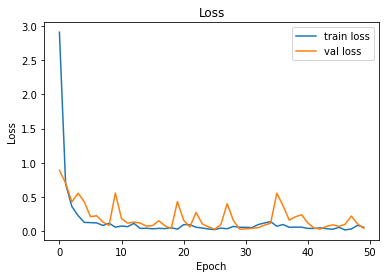

In [90]:
# loss
plt.plot(densenet.history['loss'], label='train loss')
plt.plot(densenet.history['val_loss'], label='val loss')
plt.title(label = 'Loss', fontsize = 12, color = "black")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
#plt.savefig('DenseNet_loss')

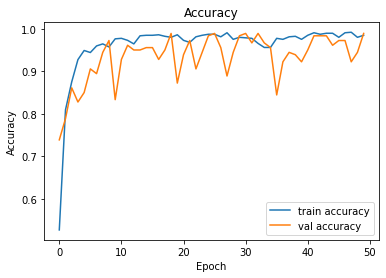

In [91]:
# accuracy
plt.plot(densenet.history['accuracy'], label='train accuracy')
plt.plot(densenet.history['val_accuracy'], label='val accuracy')
plt.title(label = 'Accuracy', fontsize = 12, color = "black")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
#plt.savefig('DenseNet_accuracy')

**7. NASNetMobile**

In [92]:
from keras.applications.nasnet import NASNetMobile
from keras.applications.nasnet import preprocess_input

# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = '/content/gdrive/MyDrive/Journal_paper/Database/train'
valid_path = '/content/gdrive/MyDrive/Journal_paper/Database/valid'
test_path = '/content/gdrive/MyDrive/Journal_paper/Database/test'

In [93]:
# add preprocessing layer to the front of NASNetMobile
nasnet = NASNetMobile(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

19996672/19993432 [==============================] - 0s 0us/step


In [94]:
# don't train existing weights
for layer in nasnet.layers:
  layer.trainable = False

In [95]:
# useful for getting number of classes
folders = glob('/content/gdrive/MyDrive/Journal_paper/Database/train/*')

In [96]:
# our layers - you can add more if you want
x = Flatten()(nasnet.output)

In [97]:
#x = Dense(3, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

In [98]:
# create a model object
model = Model(inputs=nasnet.input, outputs=prediction)

In [ ]:
# view the structure of the model
#model.summary()

In [99]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [100]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

valid_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

# Flow training images in batches of 64 using train_datagen generator
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

valid_set = valid_datagen.flow_from_directory(valid_path,
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 64,
                                            class_mode = 'categorical')

Found 840 images belonging to 3 classes.
Found 180 images belonging to 3 classes.
Found 180 images belonging to 3 classes.


In [101]:
# fit the model
nasnet = model.fit(
  training_set,
  validation_data=valid_set,
  epochs=50,
  steps_per_epoch=len(training_set),
  validation_steps=len(valid_set)
)

Epoch 1/50
14/14 [==============================] - 30s 1s/step - loss: 4.8997 - accuracy: 0.4398 - val_loss: 2.7085 - val_accuracy: 0.6111
Epoch 2/50
14/14 [==============================] - 13s 907ms/step - loss: 2.1072 - accuracy: 0.6649 - val_loss: 1.7433 - val_accuracy: 0.6611
Epoch 3/50
14/14 [==============================] - 12s 881ms/step - loss: 0.7911 - accuracy: 0.8077 - val_loss: 0.7097 - val_accuracy: 0.8222
Epoch 4/50
14/14 [==============================] - 12s 883ms/step - loss: 0.3851 - accuracy: 0.8718 - val_loss: 0.4343 - val_accuracy: 0.8722
Epoch 5/50
14/14 [==============================] - 12s 883ms/step - loss: 0.4814 - accuracy: 0.8647 - val_loss: 0.2680 - val_accuracy: 0.9111
Epoch 6/50
14/14 [==============================] - 12s 882ms/step - loss: 0.2903 - accuracy: 0.9109 - val_loss: 0.3399 - val_accuracy: 0.9000
Epoch 7/50
14/14 [==============================] - 13s 885ms/step - loss: 0.2054 - accuracy: 0.9289 - val_loss: 0.2543 - val_accuracy: 0.9056
Ep

In [102]:
# testing
score = model.evaluate(test_set, verbose=0)
print(f'Test loss: {score[0]:.4f}')
print(f'Test accuracy: {score[1]:.4f}')

Test loss: 0.0494
Test accuracy: 0.9833


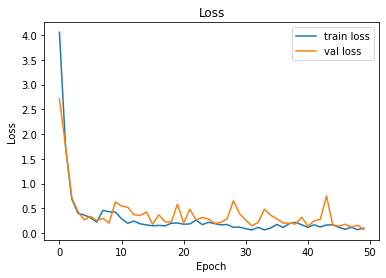

In [103]:
# loss
plt.plot(nasnet.history['loss'], label='train loss')
plt.plot(nasnet.history['val_loss'], label='val loss')
plt.title(label = 'Loss', fontsize = 12, color = "black")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
#plt.savefig('NASNetMobile_loss')

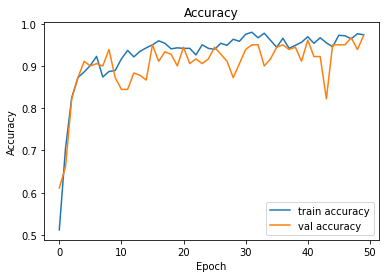

In [104]:
# accuracy
plt.plot(nasnet.history['accuracy'], label='train accuracy')
plt.plot(nasnet.history['val_accuracy'], label='val accuracy')
plt.title(label = 'Accuracy', fontsize = 12, color = "black")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
#plt.savefig('NASNetMobile_accuracy')

**8. EfficientNet**

In [105]:
!pip install -U efficientnet

     |████████████████████████████████| 51kB 5.4MB/s 


In [108]:
import efficientnet.keras as efn
from efficientnet.keras import EfficientNetB0

# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = '/content/gdrive/MyDrive/Journal_paper/Database/train'
valid_path = '/content/gdrive/MyDrive/Journal_paper/Database/valid'
test_path = '/content/gdrive/MyDrive/Journal_paper/Database/test'

In [109]:
# add preprocessing layer to the front of EfficientNetB0
efficientnet = EfficientNetB0(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

16809984/16804768 [==============================] - 1s 0us/step


In [110]:
# don't train existing weights
for layer in efficientnet.layers:
  layer.trainable = False

In [111]:
# useful for getting number of classes
folders = glob('/content/gdrive/MyDrive/Journal_paper/Database/train/*')

In [112]:
# our layers - you can add more if you want
x = Flatten()(efficientnet.output)

In [113]:
#x = Dense(3, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

In [114]:
# create a model object
model = Model(inputs=efficientnet.input, outputs=prediction)

In [ ]:
# view the structure of the model
#model.summary()

In [115]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [116]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

valid_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

# Flow training images in batches of 64 using train_datagen generator
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

valid_set = valid_datagen.flow_from_directory(valid_path,
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 64,
                                            class_mode = 'categorical')

Found 840 images belonging to 3 classes.
Found 180 images belonging to 3 classes.
Found 180 images belonging to 3 classes.


In [117]:
# fit the model
efficientnet = model.fit(
  training_set,
  validation_data=valid_set,
  epochs=50,
  steps_per_epoch=len(training_set),
  validation_steps=len(valid_set)
)

Epoch 1/50
14/14 [==============================] - 20s 979ms/step - loss: 5.3463 - accuracy: 0.3770 - val_loss: 1.5909 - val_accuracy: 0.7556
Epoch 2/50
14/14 [==============================] - 12s 849ms/step - loss: 1.5138 - accuracy: 0.6611 - val_loss: 0.5889 - val_accuracy: 0.8056
Epoch 3/50
14/14 [==============================] - 12s 866ms/step - loss: 0.7496 - accuracy: 0.7690 - val_loss: 0.2148 - val_accuracy: 0.9056
Epoch 4/50
14/14 [==============================] - 12s 861ms/step - loss: 0.5166 - accuracy: 0.8414 - val_loss: 0.2565 - val_accuracy: 0.9056
Epoch 5/50
14/14 [==============================] - 12s 861ms/step - loss: 0.3109 - accuracy: 0.8774 - val_loss: 0.3125 - val_accuracy: 0.9000
Epoch 6/50
14/14 [==============================] - 12s 855ms/step - loss: 0.3411 - accuracy: 0.8778 - val_loss: 0.3699 - val_accuracy: 0.8611
Epoch 7/50
14/14 [==============================] - 12s 868ms/step - loss: 0.2593 - accuracy: 0.9113 - val_loss: 0.3983 - val_accuracy: 0.8722

In [119]:
# testing
score = model.evaluate(test_set, verbose=0)
print(f'Test loss: {score[0]:.4f}')
print(f'Test accuracy: {score[1]:.4f}')

Test loss: 0.1018
Test accuracy: 0.9667


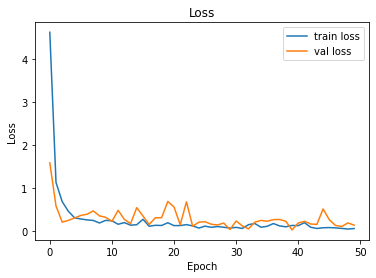

In [120]:
# loss
plt.plot(efficientnet.history['loss'], label='train loss')
plt.plot(efficientnet.history['val_loss'], label='val loss')
plt.title(label = 'Loss', fontsize = 12, color = "black")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
#plt.savefig('EfficientNetB0_loss')

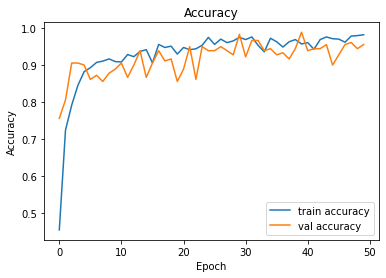

In [121]:
# accuracy
plt.plot(efficientnet.history['accuracy'], label='train accuracy')
plt.plot(efficientnet.history['val_accuracy'], label='val accuracy')
plt.title(label = 'Accuracy', fontsize = 12, color = "black")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
#plt.savefig('EfficientNetB0_accuracy')

**The accuracy comparison charts:**

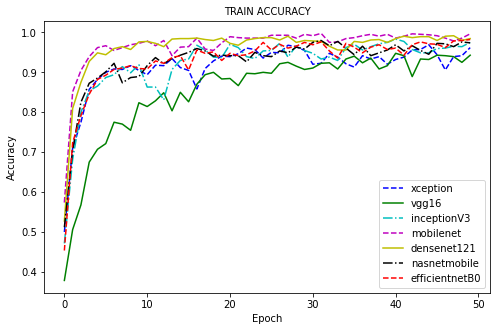

In [124]:
# train accuracy
fig, axes = plt.subplots(1, 1, figsize=(8, 5))
plt.plot(xception.history['accuracy'], '--b', label='xception')
plt.plot(vgg16.history['accuracy'], '-g', label='vgg16')
#plt.plot(resnet.history['accuracy'], '-.r', label='resnet50')
plt.plot(inception.history['accuracy'], '-.c', label='inceptionV3')
plt.plot(mobilenet.history['accuracy'], '--m', label='mobilenet')
plt.plot(densenet.history['accuracy'], '-y', label='densenet121')
plt.plot(nasnet.history['accuracy'], '-.k', label='nasnetmobile')
plt.plot(efficientnet.history['accuracy'], '--r', label='efficientnetB0')
plt.title(label = 'TRAIN ACCURACY', fontsize = 10, color = "black")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
fig.savefig('train_accuracy_01')

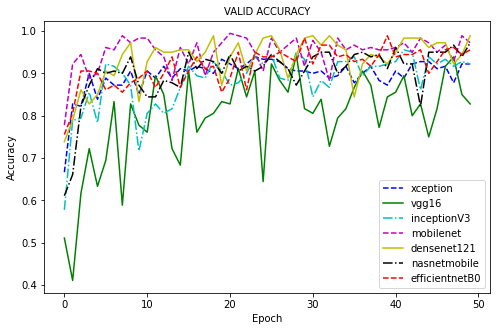

In [125]:
# valid accuracy
fig, axes = plt.subplots(1, 1, figsize=(8, 5))
plt.plot(xception.history['val_accuracy'], '--b', label='xception')
plt.plot(vgg16.history['val_accuracy'], '-g', label='vgg16')
#plt.plot(resnet.history['val_accuracy'], '-.r', label='resnet50')
plt.plot(inception.history['val_accuracy'], '-.c', label='inceptionV3')
plt.plot(mobilenet.history['val_accuracy'], '--m', label='mobilenet')
plt.plot(densenet.history['val_accuracy'], '-y', label='densenet121')
plt.plot(nasnet.history['val_accuracy'], '-.k', label='nasnetmobile')
plt.plot(efficientnet.history['val_accuracy'], '--r', label='efficientnetB0')
plt.title(label = 'VALID ACCURACY', fontsize = 10, color = "black")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
fig.savefig('valid_accuracy_01')

**The loss comparison charts:**

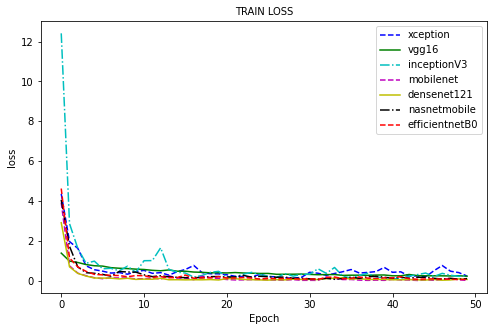

In [126]:
# train loss
fig, axes = plt.subplots(1, 1, figsize=(8, 5))
plt.plot(xception.history['loss'], '--b', label='xception')
plt.plot(vgg16.history['loss'], '-g', label='vgg16')
#plt.plot(resnet.history['loss'], '-.r', label='resnet50')
plt.plot(inception.history['loss'], '-.c', label='inceptionV3')
plt.plot(mobilenet.history['loss'], '--m', label='mobilenet')
plt.plot(densenet.history['loss'], '-y', label='densenet121')
plt.plot(nasnet.history['loss'], '-.k', label='nasnetmobile')
plt.plot(efficientnet.history['loss'], '--r', label='efficientnetB0')
plt.title(label = 'TRAIN LOSS', fontsize = 10, color = "black")
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend()
plt.show()
fig.savefig('train_loss_01')

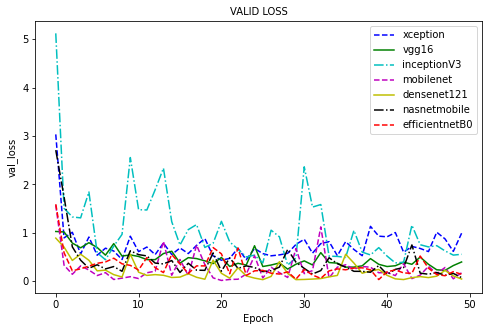

In [127]:
# valid loss
fig, axes = plt.subplots(1, 1, figsize=(8, 5))
plt.plot(xception.history['val_loss'], '--b', label='xception')
plt.plot(vgg16.history['val_loss'], '-g', label='vgg16')
#plt.plot(resnet.history['val_loss'], '-.r', label='resnet50')
plt.plot(inception.history['val_loss'], '-.c', label='inceptionV3')
plt.plot(mobilenet.history['val_loss'], '--m', label='mobilenet')
plt.plot(densenet.history['val_loss'], '-y', label='densenet121')
plt.plot(nasnet.history['val_loss'], '-.k', label='nasnetmobile')
plt.plot(efficientnet.history['val_loss'], '--r', label='efficientnetB0')
plt.title(label = 'VALID LOSS', fontsize = 10, color = "black")
plt.xlabel('Epoch')
plt.ylabel('val_loss')
plt.legend()
plt.show()
fig.savefig('valid_loss_01')